## baseline fit and covariance estimation

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'
#%load_ext autoreload

from multiprocessing import Pool
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm import tqdm_notebook, trange

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
plot_labels = fh.fancy_labels

np.set_printoptions(precision=3)
rc_params = {
             'figure.figsize': (10, 10),
             'axes.labelsize': 20,
             'axes.facecolor': 'white',
             'axes.titlesize':'x-large',
    
             'legend.fontsize': 20,
             'xtick.labelsize':18,
             'ytick.labelsize':18,
             'font.size':18,
             'font.sans-serif':['Arial', 'sans-serif'],
             'mathtext.sf':'Arial',
             'lines.markersize':8.,
             'lines.linewidth':2.5,
            }
matplotlib.rcParams.update(rc_params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 59009,
  "iopub_port": 56811,
  "stdin_port": 42151,
  "control_port": 35381,
  "hb_port": 37967,
  "ip": "127.0.0.1",
  "key": "12a29f23-1361010c1e09a3499ea220e2",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-4bec8cc5-b14d-4983-b777-e0ab4ee65114.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# configure, get the input data, and do any additional processing that is needed
processes = ['ttbar', 't', 'ww', 'wjets', 'zjets_alt', 'gjets', 'diboson', 'fakes'] 
selections = [
    'ee',  
    'mumu',  
    'emu', 
    'etau',  
    'mutau',
    'ejet', 
    'mujet',
             ]
veto_list = [
    
    # baseline categories
    #'ee_cat_gt2_eq1_b',  #'mumu_cat_gt2_eq1_b', 
    #'ee_cat_gt2_gt2_b',  #'mumu_cat_gt2_gt2_b', 
    
    #'emu_cat_gt2_eq1_a', 
    #'etau_cat_eq2_eq1', 'etau_cat_gt3_eq1', 
    #'mutau_cat_eq2_eq1', 'mutau_cat_gt3_eq1', 
    #'emu_cat_gt2_gt2_a', 
    #'etau_cat_eq2_gt2', 'etau_cat_gt3_gt2', 
    #'mutau_cat_eq2_gt2', 'mutau_cat_gt3_gt2', 
    
    #'ejet_cat_gt4_eq1',  #'mujet_cat_gt4_eq1', 
    #'ejet_cat_gt4_gt2', #'mujet_cat_gt4_gt2', 
    
    # experimental semi-leptonic
    'ejet_cat_eq3_gt2', 'mujet_cat_eq3_gt2',
    
    # e/mu DY CR (*fobidden*)
    'ee_cat_gt2_eq0',  'mumu_cat_gt2_eq0', 
    
    # e+mu additional ttbar
    #'emu_cat_gt2_eq0', 'emu_cat_eq1_eq0_a', #'emu_cat_eq1_eq1_a',
    
    # e+mu WW
    #'emu_cat_eq0_eq0_a', 
    
    # e/mu+tau additional CR
    #'mutau_cat_eq0_eq0', 'mutau_cat_eq1_eq0', 
    #'mutau_cat_gt2_eq0', 'mutau_cat_eq1_eq1', 
    #'etau_cat_eq0_eq0', 'etau_cat_eq1_eq0', 
    #'etau_cat_gt2_eq0', 'etau_cat_eq1_eq1', 
]

# initialize fit data
input_dir  = f'local_data/templates/test_08242020_jetavg/'
fit_data = fh.FitData(input_dir, selections, processes, 
                      param_file = 'data/model_parameters_default.csv',
                      use_prefit = False,
                      process_cut = 0.05,
                      veto_list   = veto_list,
                      debug_mode  = False,
                      ratio_test  = False
                     )

In [3]:
# prepare Asimov dataset
parameters = fit_data._parameters
params_pre = parameters['val_init'].values
if fit_data._ratio_test:
    params_pre[:2] = params_pre[2]
    asimov_data = {cat:fit_data.mixture_model(params_pre, cat) for cat in fit_data._model_data.keys()}
    params_pre[:2] = 1.
else:
    asimov_data = {cat:fit_data.mixture_model(params_pre, cat) for cat in fit_data._model_data.keys()}

# randomize initial values and values of constraints
#fit_data._pval_init[4:] += np.random.randn(fit_data._nparams - 4)*fit_data._perr_init[4:]

In [4]:
# fit configuration #
scenario = 'unblinded'

# minimizer options
min_options = dict(#eps=1e-9, 
                   gtol = 1e-3,
                   disp = True
                  )

# configure the objective
#fit_data._pmask[4:] = False
mask = fit_data._pmask.copy()
if scenario == 'unblinded':
    sample = None
else:
    sample = asimov_data
    
fobj = partial(fit_data.objective,
               data = sample,
               do_bb_lite = True,
               no_shape = False,
               lu_test = 0,
              )

fobj_jac = partial(fit_data.objective_jacobian,
                   data = sample,
                   do_bb_lite = True,
                   no_shape = False,
                   lu_test = 0
                  )


In [5]:
# carry out fit for null hypothesis
result_null = minimize(fobj, params_pre[mask],
                       jac = fobj_jac,
                       method  = 'BFGS', 
                       options = min_options,
                       args = ()
                      )

print(' null : ', result_null.status, result_null.fun, result_null.x[:4]*100)

         Current function value: 265.814684
         Iterations: 63
         Function evaluations: 163
         Gradient evaluations: 151
 null :  2 265.81468402721316 [10.872 10.872 10.872 67.385]


In [6]:
# carry out fit for null hypothesis
#result_null = minimize(fobj, params_pre[mask],
#                       jac = fobj_jac,
#                       hess = '2-point',
#                       method  = 'trust-constr', 
#                       #method  = 'BFGS', 
#                       options = {'verbose': 2, 'gtol':1.},
#                       args = ()
#                      )
#
#print(' null : ', result_null.status, result_null.fun, result_null.x[:4]*100)

In [7]:
# carry out fit for alt 1
fobj.keywords['lu_test'] = 1
fobj_jac.keywords['lu_test'] = 1
result_alt1 = minimize(fobj, params_pre[mask],
                       jac     = fobj_jac,
                       method  = 'BFGS', 
                       options = min_options,
                       args = ()
                      )
        
print(' alt. 1: ', result_alt1.status, result_alt1.fun, result_alt1.x[:4]*100)

         Current function value: 265.818961
         Iterations: 62
         Function evaluations: 163
         Gradient evaluations: 151
 alt. 1:  2 265.8189608137187 [10.872 10.872 10.892 67.364]


In [8]:
# carry out fit for alt hypothesis
#fobj.keywords['lu_test'] = 1
#fobj_jac.keywords['lu_test'] = 1
#pinit = result_null.x.copy()
#result_alt1 = minimize(fobj, pinit,
#                       jac = fobj_jac,
#                       hess = '2-point',
#                       method  = 'trust-constr', 
#                       #method  = 'BFGS', 
#                       options = {'verbose': 2, 'gtol':0.1},
#                       args = ()
#                      )
#
#print('alt. 1: ', result_alt1.status, result_alt1.fun, result_alt1.x[:4]*100)

In [9]:
# carry out fit for alt 2
fobj.keywords['lu_test'] = 2
fobj_jac.keywords['lu_test'] = 2
result_alt2 =  minimize(fobj, params_pre[mask],
                        jac     = fobj_jac,
                        method  = 'BFGS', 
                        options = min_options,
                        #bounds  = bnds,
                       )

print(' alt. 2: ', result_alt2.status, result_alt2.fun, result_alt2.x[:4]*100)

         Current function value: 264.651047
         Iterations: 61
         Function evaluations: 130
         Gradient evaluations: 118
 alt. 2:  2 264.65104699916543 [10.773 10.911 10.894 67.422]


In [10]:
# Wilk's theorem
from scipy.stats import chi2, norm
q1 = 2*(result_null.fun - result_alt1.fun)
z1 = -norm.ppf(chi2.sf(q1, 1))

q2 = 2*(result_null.fun - result_alt2.fun)
z2 = -norm.ppf(chi2.sf(q2, 2))

print(f' test hypothesis 1: q = {q1:.1f}, z = {z1:.1f}')
print(f' test hypothesis 2: q = {q2:.1f}, z = {z2:.1f}')

 test hypothesis 1: q = -0.0, z = -inf
 test hypothesis 2: q = 2.3, z = 0.5


In [11]:

# calculate covariance matrix assuming LU
print('Calculating covariance for null hypothesis (LU)...')
p_mle = result_null.x
fobj.keywords['lu_test'] = 0
fobj_jac.keywords['lu_test'] = 0
stderr_lu, corr_lu = fh.calculate_covariance(fobj, p_mle)

# calculate covariance matrix assuming semi-LU
print('Calculating covariance for partial LU hypothesis...')
p_mle = result_alt1.x
fobj.keywords['lu_test'] = 1
fobj_jac.keywords['lu_test'] = 1
stderr_plu, corr_plu = fh.calculate_covariance(fobj, p_mle)

# calculate covariance matrix from the inverse of the Hessian of the NLL
print('Calculating covariance for non-LU hypothesis...')
p_mle = result_alt2.x
fobj.keywords['lu_test'] = 2
fobj_jac.keywords['lu_test'] = 2
stderr, corr = fh.calculate_covariance(fobj, p_mle)

# no MC stat
print('Calculating covariance without MC stats nuisance parameters...')
fit_data._pmask = parameters['active'].values.astype(bool)
mask = fit_data._pmask.copy()
fobj.keywords['do_bb_lite'] = False
fobj_jac.keywords['do_bb_lite'] = False
result_no_bb =  minimize(fobj, params_pre[mask],
                    jac     = fobj_jac,
                    method  = 'BFGS', 
                    options = min_options,
                    #bounds  = bnds,
                    )
p_no_bb = result_no_bb.x
err_no_bb, _ = fh.calculate_covariance(fobj, p_no_bb)

# stat only
print('Calculating covariance without any nuisance parameters...')
fit_data._pmask[4:] = False
result_stat =  minimize(fobj, params_pre[:4],
                    jac     = fobj_jac,
                    method  = 'BFGS', 
                    options = min_options,
                    #bounds  = bnds,
                    )
p_stat = result_stat.x
err_stat, _ = fh.calculate_covariance(fobj, p_stat)
err_stat = np.concatenate([err_stat, np.zeros(p_mle.size - 4)])

# w/ MC stat, but no systematics
#print('Calculating covariance with only MC stat nuisance parameters...')
fobj.keywords['do_bb_lite'] = True
fobj_jac.keywords['do_bb_lite'] = True
#err_mc_stat_alt, _ = fh.calculate_covariance(fobj, p_mle[:4])
#err_mc_stat_alt = np.concatenate([err_mc_stat_alt, np.zeros(p_mle.size - 4)])
mask = parameters['active'].values.astype(bool)

# combine components
err_syst = np.sqrt(err_no_bb**2 - err_stat**2)
err_mc_stat = np.sqrt(stderr**2 - err_no_bb**2)
#err_mc_stat_alt = np.sqrt(err_mc_stat_alt**2 - err_stat**2)

Calculating covariance for null hypothesis (LU)...
Calculating covariance for partial LU hypothesis...
Calculating covariance for non-LU hypothesis...
Calculating covariance without MC stats nuisance parameters...
Optimization terminated successfully.
         Current function value: 474.619156
         Iterations: 82
         Function evaluations: 142
         Gradient evaluations: 140
Calculating covariance without any nuisance parameters...
         Current function value: 898.417970
         Iterations: 11
         Function evaluations: 87
         Gradient evaluations: 77


In [12]:
# plot errors
parameters = fit_data._parameters
parameters['val_fit'] = parameters['val_init'].copy()
parameters['err_fit'] = parameters['err_init'].copy()
parameters.loc[mask, 'val_fit'] = result_alt2.x
parameters.loc[mask, 'err_fit'] = stderr
parameters['ratio'] = parameters.err_fit/parameters.err_init

parameters['val_no_bb'] = parameters['val_init'].copy()
parameters['err_no_bb'] = parameters['err_init'].copy()
parameters.loc[mask, 'val_no_bb'] = p_no_bb
parameters.loc[mask, 'err_no_bb'] = err_no_bb

parameters['val_stat'] = parameters['val_init'].copy()
parameters['err_stat'] = parameters['err_init'].copy()
mask[4:] = False
parameters.loc[mask, 'val_stat'] = p_stat
parameters.loc[mask, 'err_stat'] = err_stat[:4]
mask = parameters['active'].values.astype(bool)

# scale branching fraction values
#param_mask = np.array(parameters.type == 'poi', dtype=bool)
#val_init = parameters.loc[param_mask, 'val_init']
#parameters.loc[param_mask, 'err_init'] *= 100/val_init
#parameters.loc[param_mask, 'err_fit'] *= 100/val_init

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', parameters.shape[0])
pd.set_option('display.max_rows', parameters.shape[0])

# plot nuisance parameter errors and constraints
parameters.set_index('label')
parameters.to_csv(f'data/model_parameters_{scenario}.csv')

# save fit data as input to full fit
outfile = open(f'local_data/fit_data_{scenario}.pkl', 'wb')
fit_data._pmask = parameters['active'].values.astype(bool)
pickle.dump(fit_data, outfile)
outfile.close()
###

df = parameters.query('active == 1')[['val_init', 'err_init', 'val_stat', 'err_stat', 'val_no_bb', 'err_no_bb', 'val_fit', 'err_fit', 'ratio']]
df = df.astype('float64')
df.style.bar(subset=['ratio'], align='mid', color=['#d65f5f', '#5fba7d']).set_precision(4)

,val_init,err_init,val_stat,err_stat,val_no_bb,err_no_bb,val_fit,err_fit,ratio
name,,,,,,,,,
beta_e,0.1080,0.1080,0.1050,0.0001,0.1065,0.0009,0.1077,0.0010,0.0092
beta_mu,0.1080,0.1080,0.1059,0.0001,0.1085,0.0007,0.1091,0.0008,0.0073
beta_tau,0.1080,0.1080,0.1059,0.0005,0.1088,0.0017,0.1089,0.0021,0.0191
beta_h,0.6760,0.6760,0.6831,0.0004,0.6761,0.0024,0.6742,0.0028,0.0041
br_tau_e,0.1774,0.0004,0.1774,0.0004,0.1774,0.0004,0.1774,0.0004,0.9998
br_tau_mu,0.1730,0.0004,0.1730,0.0004,0.1731,0.0004,0.1731,0.0004,0.9983
br_tau_h,0.6496,0.0010,0.6496,0.0010,0.6494,0.0010,0.6495,0.0010,0.9994
lumi,1.0000,0.0250,1.0000,0.0250,1.0252,0.0171,1.0100,0.0179,0.7164
xs_gjets,1.0000,0.1000,1.0000,0.1000,1.0982,0.0930,1.0846,0.0953,0.9534


In [13]:
# produce correlation matrix
p_labels = list(parameters.index)
p_labels_fancy = fit_data._parameters.label[mask]

# full fit
df_corr = pd.DataFrame(corr, columns=p_labels_fancy, index=p_labels_fancy)
df_corr.to_latex(f'local_data/corr_table_full_{scenario}.tex')
df_corr.to_csv(f'local_data/corr_table_full_{scenario}.csv')

# partial LU fit
df_corr_plu = pd.DataFrame(corr_plu, columns=p_labels_fancy, index=p_labels_fancy)
df_corr_plu.to_latex(f'local_data/corr_table_full_plu_{scenario}.tex')
df_corr_plu.to_csv(f'local_data/corr_table_full_plu_{scenario}.csv')

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


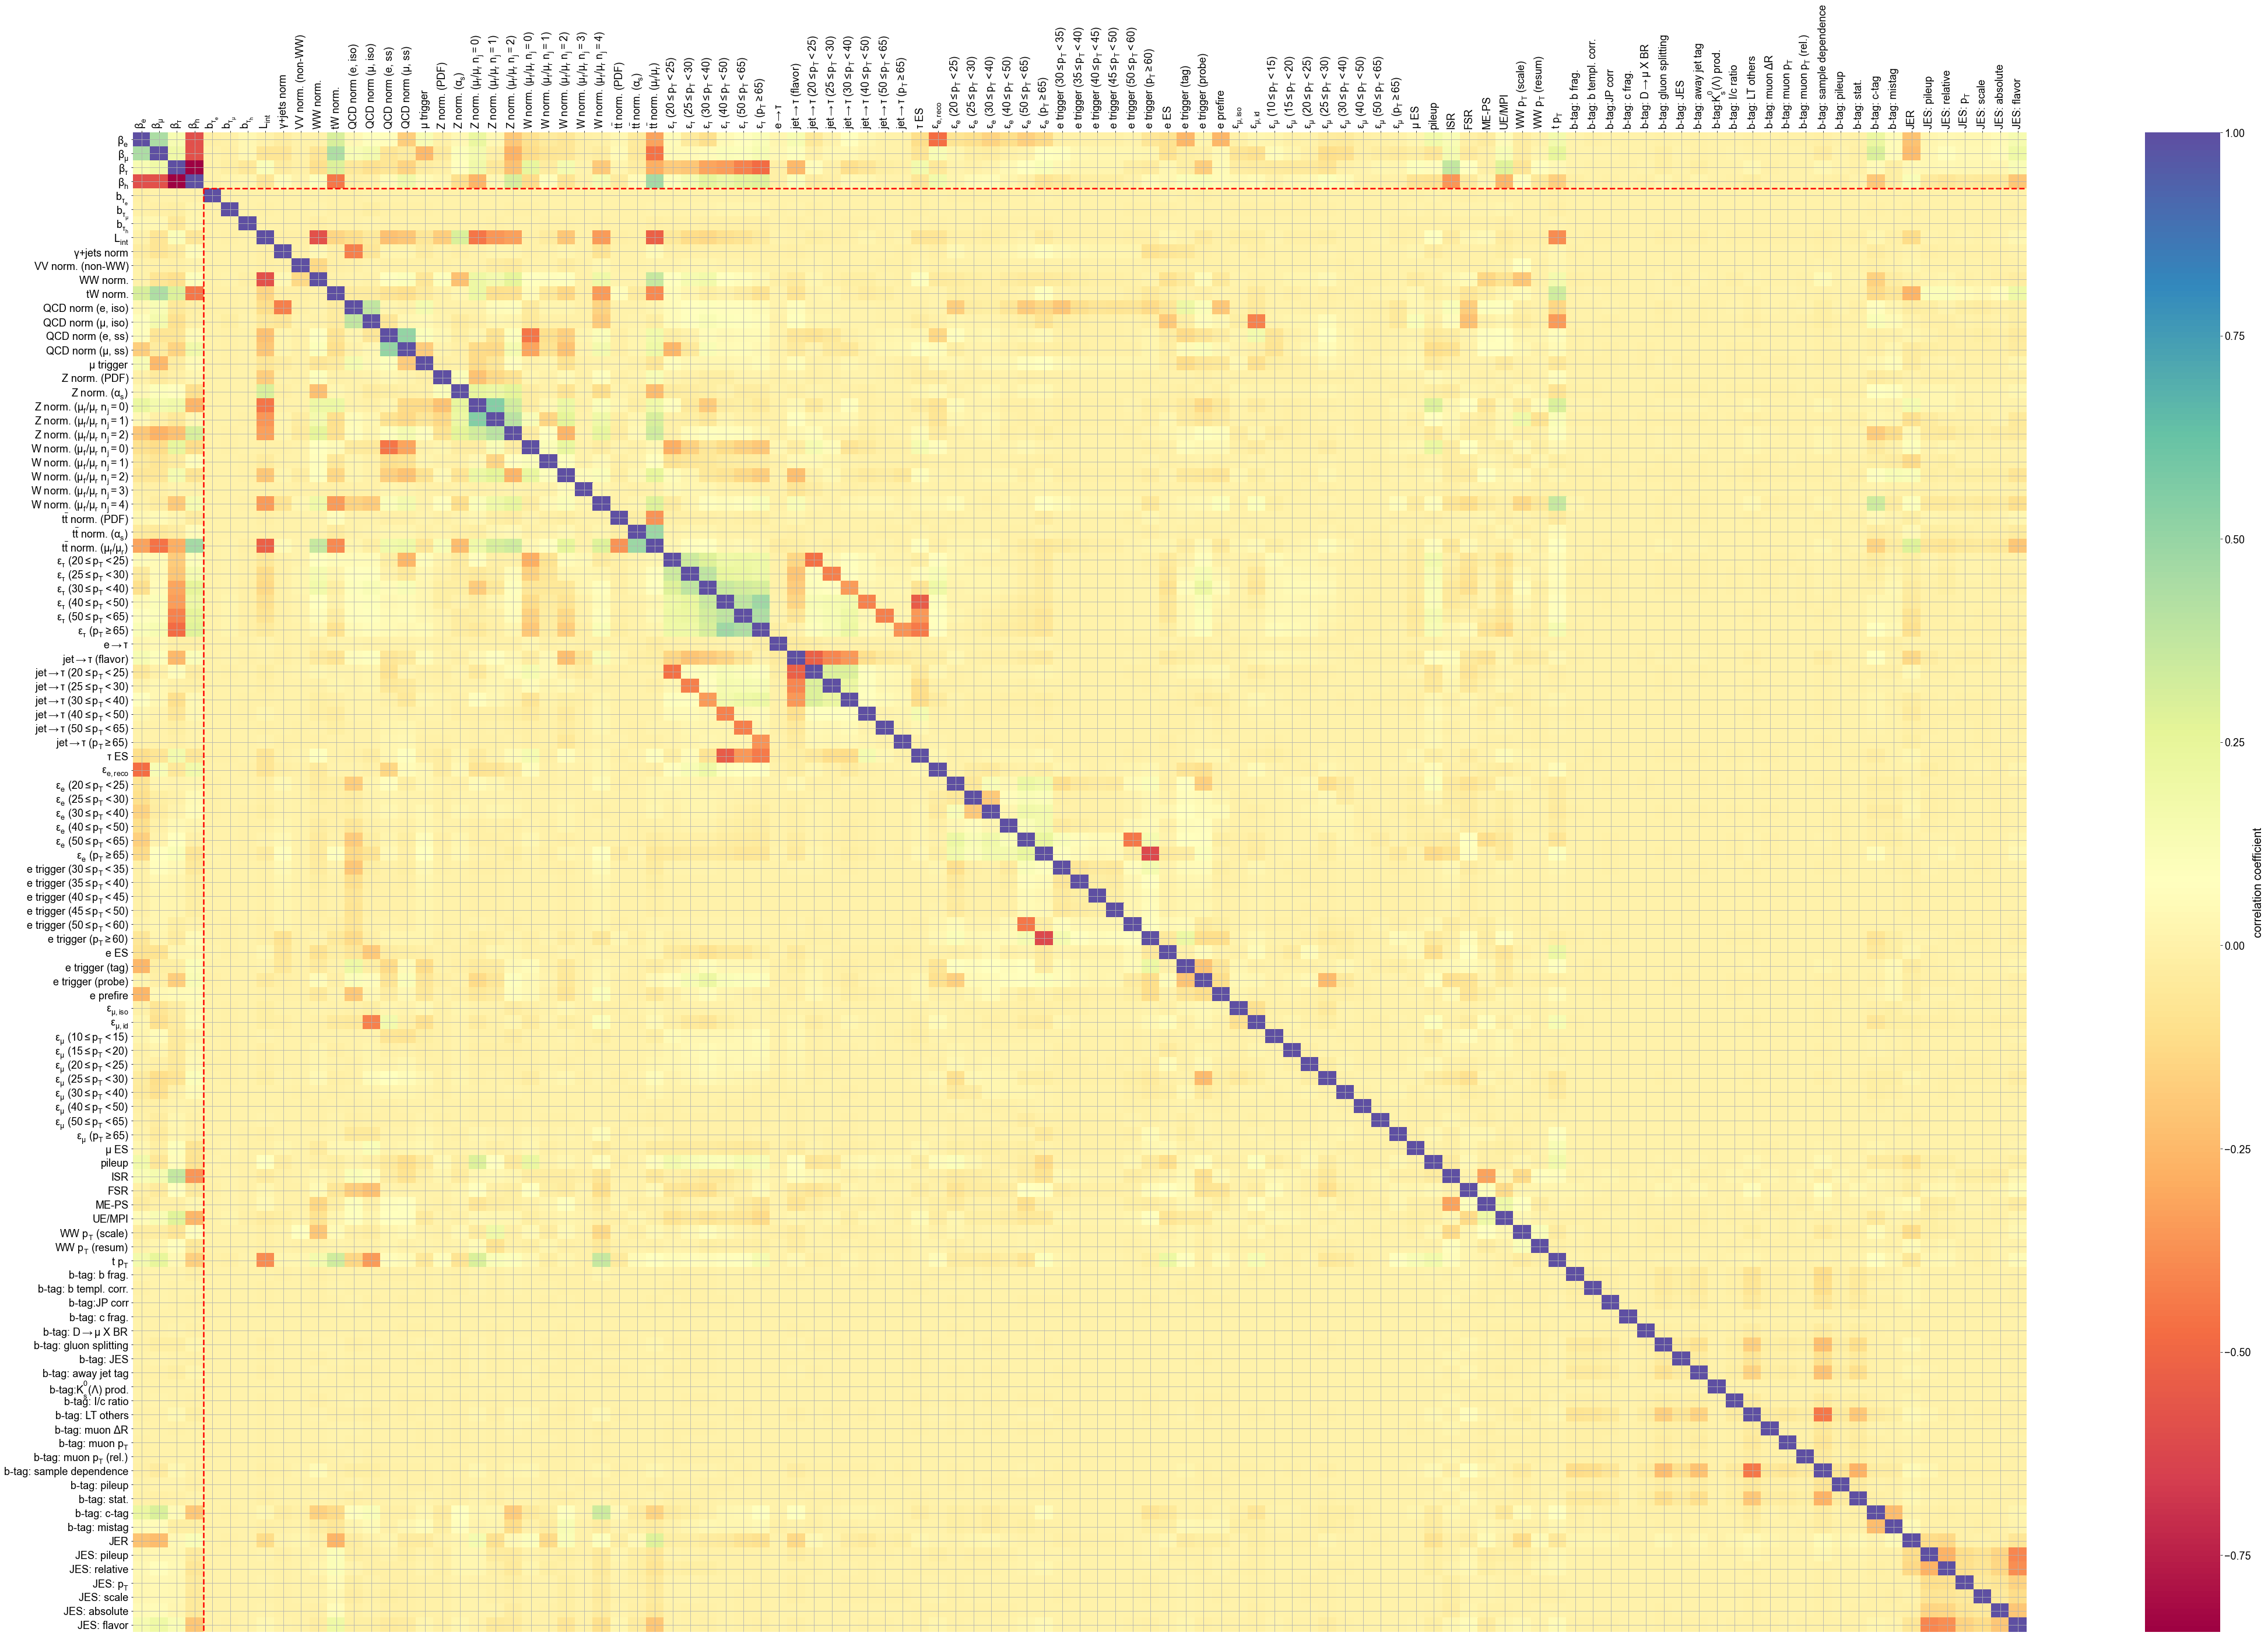

In [14]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(60, 40))
sns.heatmap(df_corr, cmap='Spectral', annot=False, fmt='.2f', ax=ax, cbar_kws={'label': r'correlation coefficient'})
plt.plot([4, df_corr.shape[0]], [4, 4], 'r--')
plt.plot([4, 4], [4, df_corr.shape[0]], 'r--')
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.tick_top()
ax.grid()
#ax.xaxis.set_ticks(np.arange(0, df_corr.shape[0], 1))
plt.xticks(rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig(f'plots/systematics/correlation_matrix_{scenario}.pdf')
plt.show()

[0.924 0.732 1.914 2.582] [0.924 0.732 1.914 2.582]


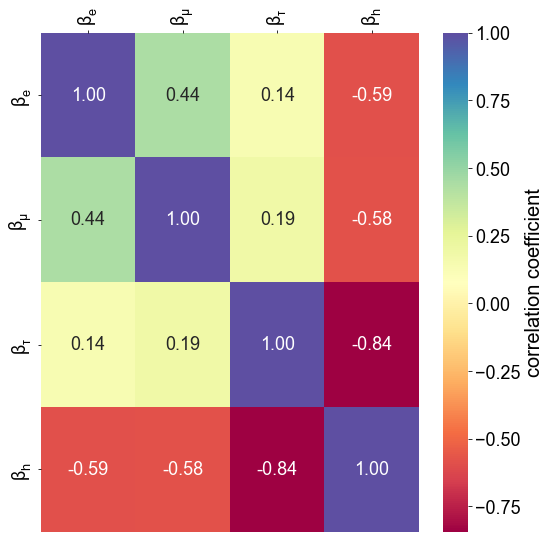

In [19]:
# produce correlation matrix
fig, axes = plt.subplots(1, 1, facecolor='white', figsize=(8, 8))

ax = axes
sns.heatmap(df_corr.iloc[:4, :4], cmap='Spectral', annot=True, fmt='.2f', ax=ax, cbar_kws={'label': r'correlation coefficient'})
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.tick_top()
#ax.xaxis.set_ticks(np.arange(0, df_corr.shape[0], 1))
plt.xticks(rotation=90)

# transform W branching fraction covariance by marginalizing over nuisance parameters
cov = corr*np.outer(stderr, stderr)
cov_inv = np.linalg.pinv(cov)
U0 = cov_inv[:4, :4]
V = cov_inv[:4, 4:]
W0_inv = np.linalg.pinv(cov_inv[4:, 4:])
IX = np.dot(V, np.dot(W0_inv, V.T))
U = (U0 - IX)

cov_new = np.linalg.pinv(U)
err_new = np.sqrt(cov_new.diagonal())
corr_new =  cov_new/np.outer(err_new, err_new)
df_corr_marginal = pd.DataFrame(corr_new, columns=p_labels_fancy[:4], index=p_labels_fancy[:4])
print(100*err_new[:4]/0.108, 100*stderr[:4]/0.108)

#ax = axes[1]
#sns.heatmap(df_corr_marginal, cmap='Spectral', annot=True, fmt='.2f', ax=ax, cbar_kws={'label': r'correlation coefficient'})
#ax.set_xlabel('')
#ax.set_ylabel('')
#ax.xaxis.tick_top()
##ax.xaxis.set_ticks(np.arange(0, df_corr.shape[0], 1))
#plt.xticks(rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig(f'plots/systematics/correlation_matrix_POI_{scenario}.pdf')
plt.show()

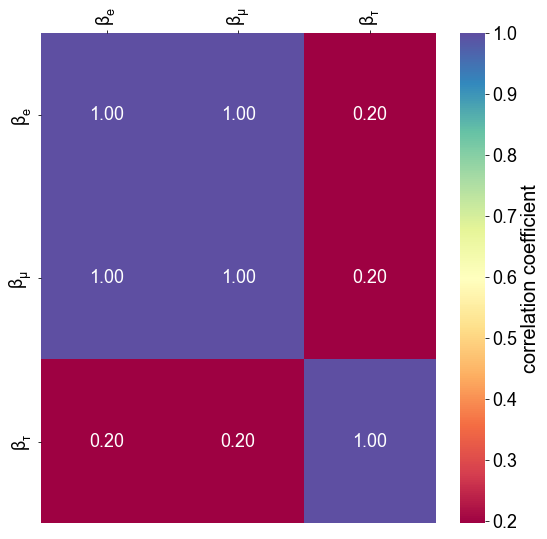

In [16]:
# produce correlation matrix
fig, axes = plt.subplots(1, 1, facecolor='white', figsize=(8, 8))

ax = axes
p_labels_plu = [r'$\beta_{e/\mu}$'] + p_labels_fancy.to_list()[2:]
df_corr_plu = pd.DataFrame(corr_plu, columns=p_labels_fancy, index=p_labels_fancy)
sns.heatmap(df_corr_plu.iloc[:3, :3], cmap='Spectral', annot=True, fmt='.2f', ax=ax, cbar_kws={'label': r'correlation coefficient'})
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.tick_top()
#ax.xaxis.set_ticks(np.arange(0, df_corr.shape[0], 1))
plt.xticks(rotation=90)

r_ltau_pdf = partial(fh.bivariate_normal_ratio,
                     mu_x=result_alt1.x[1],
                     mu_y=result_alt1.x[2],
                     sigma_x=stderr_plu[1], 
                     sigma_y=stderr_plu[2],
                     rho=df_corr_plu.iloc[2, 1]
                    )

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig(f'plots/systematics/correlation_matrix_POI_plu_{scenario}.pdf')
plt.show()

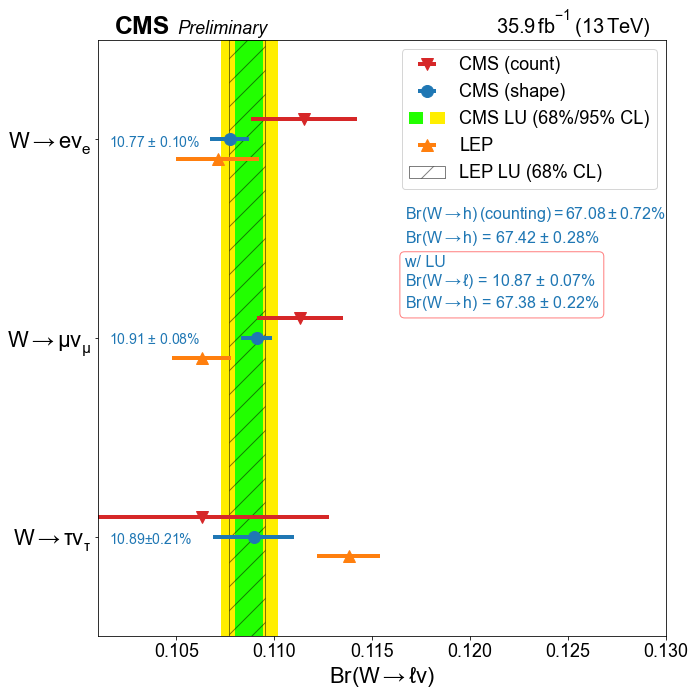

In [17]:
# presentation of results
fig, axes = plt.subplots(1, 1, figsize=(10, 10), facecolor='white')

ax = axes
br_cms = result_alt2.x[:4]
p0_alt = ax.errorbar([.1063, .1113, .1115], np.arange(3) + 0.1, xerr=[0.0065, 0.0022, 0.0027],
            fmt='C3v',
            markersize=12.,
            capsize=0.,
            elinewidth=4,
            label='CMS (alt.)'
           )
p0 = ax.errorbar(br_cms[2::-1], np.arange(3), xerr=stderr[2::-1], 
            fmt='C0o',
            markersize=12.,
            capsize=0.,
            elinewidth=4,
            label='CMS'
           )
br_lep_lu = result_null.x[0]
br_had_lu = result_null.x[3]
#ax.plot(2*[br_lu,], [-0.5, 2.5], 'C0--')
colors = ['#22FF00', '#FFEE00']
p1 = ax.fill_betweenx([-0.5, 2.5], br_lep_lu-stderr_lu[0], br_lep_lu+stderr_lu[0], alpha=1., facecolor=colors[0], label='CMS w/ LU')
p2 = ax.fill_betweenx([-0.5, 2.5], br_lep_lu-2*stderr_lu[0], br_lep_lu-stderr_lu[0], alpha=1., facecolor=colors[1])
ax.fill_betweenx([-0.5, 2.5], br_lep_lu+stderr_lu[0], br_lep_lu+2*stderr_lu[0], alpha=1., facecolor=colors[1])

lep_val = [0.1071, 0.1063, 0.1138]
lep_err = [0.0016, 0.0015, 0.0021]
p3 = ax.errorbar(lep_val[::-1], np.arange(3) - 0.1, xerr=lep_err, 
            fmt='C1^',
            markersize=12.,
            capsize=0.,
            elinewidth=4,
            label='LEP'
           )
lep_avg = 0.1086, 0.0009
p4 = ax.fill_betweenx([-0.5, 2.5], lep_avg[0]-lep_avg[1], lep_avg[0]+lep_avg[1], 
                 alpha=0.5, 
                 hatch='/', 
                 edgecolor='k', 
                 facecolor='none', 
                 label='LEP w/ LU'
                )

ax.text(0.02, 0.82 , f'{100*br_cms[0]:.2f}' + r' $\pm$ ' + f'{stderr[0]:.2%}',
        fontsize=14,          
        fontname='Arial',     
        color='C0',
        transform=ax.transAxes
       )
ax.text(0.02, 0.49, f'{100*br_cms[1]:.2f}' + r' $\pm$ ' + f'{stderr[1]:.2%}',
        fontsize=14,
        fontname='Arial',     
        color='C0',
        transform=ax.transAxes
       )
ax.text(0.02, 0.155, f'{100*br_cms[2]:.2f}' + r'$ \pm $' + f'{stderr[2]:.2%}',
        fontsize=14,          
        fontname='Arial',     
        color='C0',
        transform=ax.transAxes
       )


ax.text(0.54, 0.7, r'$Br(W\rightarrow h)\,(counting) = 67.08 \pm 0.72 \%$',
        fontsize=16,          
        color='C0',
        fontname='Arial',     
        transform=ax.transAxes
       )
ax.text(0.54, 0.66, r'$Br(W\rightarrow h)$ = ' + f'{100*br_cms[3]:.2f}' + r' $\pm$ ' + f'{stderr[3]:.2%}',
        fontsize=16,          
        color='C0',
        fontname='Arial',     
        transform=ax.transAxes
       )
ax.text(0.54, 0.55, 
        'w/ LU \n'
        + r'$Br(W\rightarrow \ell)$ = ' + f'{100*br_lep_lu:.2f}' + r' $\pm$ ' + f'{stderr_lu[0]:.2%}' + '\n' 
        + r'$Br(W\rightarrow h)$ = ' + f'{100*br_had_lu:.2f}' + r' $\pm$ ' + f'{stderr_lu[3]:.2%}',
        fontsize=16,
        color='C0',
        fontname='Arial',     
        transform=ax.transAxes,
        bbox=dict(
            boxstyle="round",
            ec=(1., 0.5, 0.5),
            fc=(1., 1., 1.),
           )
       )
#ax.text(f'{br_cms[1]}' + r'$\pm$' + f'{stderr[1]}')
#ax.text(f'{br_cms[2]}' + r'$\pm$' + f'{stderr[2]}')

ax.set_yticks([0, 1, 2])
ax.set_yticklabels([r'$W\rightarrow \tau\nu_{\tau}$', r'$W\rightarrow \mu\nu_{\mu}$', r'$W\rightarrow e\nu_{e}$'], fontsize=22)
ax.set_ylim(-0.5, 2.5)
ax.set_xlim(0.101, 0.13)
ax.set_xlabel(r'Br($W\rightarrow\ell\nu$)', fontsize=22)
from matplotlib.legend_handler import HandlerTuple
ax.legend([p0_alt, p0, [p1, p2], p3, p4,], ['CMS (count)', 'CMS (shape)', 'CMS LU (68%/95% CL)', 'LEP', 'LEP LU (68% CL)',], 
          handler_map = {list: HandlerTuple(None)},
          fontsize=18,
          loc=1
         )

pt.add_lumi_text(ax, 35.9)

plt.tight_layout()
plt.savefig('plots/unblinded_summary_plot.pdf')
plt.show()

In [18]:
# calculation of |V_ij|^2 (taken from LEP EW combo arXiv:1302.3415 p.95)
alpha_s, alpha_s_err = 0.119, 0.002
br_lep_lu, br_lep_lu_err = 0.1087, 0.0007 

vij = (1 - 3*br_lep_lu)/(3*br_lep_lu*(1 + alpha_s/np.pi))

dvij_dbr = 1./(3.*br_lep_lu**2*(1 + alpha_s/np.pi))
dvij_dalpha_s = -(1 - 3*br_lep_lu )/(3*br_lep_lu*np.pi*(1 + alpha_s/np.pi)**2)

vij_var = (dvij_dbr*br_lep_lu_err)**2 + (dvij_dalpha_s*alpha_s_err)**2 

print(f'|V_ij|^2 = {vij:.4f} +/- {np.sqrt(vij_var):.4f}')

# calculation of V_cs (taken from LEP EW combo arXiv:1302.3415 p.95)
alpha_s, alpha_s_err = 0.1202, 0.001
sum_ckm, sum_ckm_err = 1.0544, 0.0051
br_lep_lu, br_lep_lu_err = 0.1087, 0.0007 

v_cs = np.sqrt((1./(3*br_lep_lu) - 1)/(1 + alpha_s/np.pi) - sum_ckm)

dv_cs_dbr = -1./(3.*br_lep_lu**2*(1 + alpha_s/np.pi)) * (0.5/v_cs)
dv_cs_dalpha_s = -(1/(3*br_lep_lu) - 1)/(np.pi + alpha_s)**2 * (0.5/v_cs)
dv_cs_dsum_ckm = -1 * (0.5/v_cs)

v_cs_var = (dv_cs_dbr*br_lep_lu_err)**2 + (dv_cs_dalpha_s*alpha_s_err)**2 + (dv_cs_dsum_ckm*sum_ckm_err)**2

print(f'V_cs = {v_cs:.4f} +/- {np.sqrt(v_cs_var):.4f}')

|V_ij|^2 = 1.9911 +/- 0.0191
V_cs = 0.9675 +/- 0.0102
